In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import io
import numpy as np
import re

### M1/M2

In [2]:
url='https://cdn.amcm.gov.mo/uploads/attachment/2024-07/1_Money_75.xlsx'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r=requests.get(url, headers=headers)
if r.ok:
    data=r

In [3]:
df=pd.read_excel(io.BytesIO(data.content), sheet_name='M2')
# col=[re.sub(r'\(.*?\)', '', i[0][1]) if (i[1][1]==None) else re.sub(r'\(.*?\)', '', i[1][1]) for i in 
#  zip(enumerate(df.iloc[8].replace(np.nan, None)), enumerate(df.iloc[10].replace(np.nan, None)))]
col=['Year', 'Month', 'M2','M2-MOP',
 'M2-HKD',
 'M2-RMB',
 'M2-USD',
 'M2-Others ',
 'M1',
 'M1-MOP',
 'M1-HKD',
 'M1-RMB',
 'M1-USD',
 'M1-Others ',
 'Quasi-monetary Liab.',
 'Liab.-MOP',
 'Liab.-HKD',
 'Liab.-RMB',
 'Liab.-USD',
 'Liab.-Others ']
df.columns=col
df=df[13:].replace('..', 0)


def fnd_previous(pos, lst):
    return fnd_previous(pos-1, lst) if lst[pos][1] is None else lst[pos][1]

lst = list(enumerate(df['Year'].replace(np.nan, None)))
df['Year'] = [fnd_previous(i, lst) for i, _ in lst]
df=df.dropna()
df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))
df=df.set_index('Date')
df_money=df

C:\Users\tonyfong\AppData\Local\Temp\ipykernel_11232\242949146.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df=df[13:].replace('..', 0)
C:\Users\tonyfong\AppData\Local\Temp\ipykernel_11232\242949146.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))


### Foreign Assets/Monetary Base

In [4]:
url='https://cdn.amcm.gov.mo/uploads/attachment/2024-07/7_Central_Bank_Survey_74.xlsx'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r=requests.get(url, headers=headers)
if r.ok:
    data=r

In [5]:
df=pd.read_excel(io.BytesIO(data.content), sheet_name='AMCM Net Foreign Assets')
col=['Year', 'Month', '', 'Net Foreign Assets', 'Foreign Assets', 'Foreign Exchange Reserves', 'Other Foreign Assets', 'Foreign Liab.']
df.columns=col
df=df[13:].replace('..', 0)


def fnd_previous(pos, lst):
    return fnd_previous(pos-1, lst) if lst[pos][1] is None else lst[pos][1]

lst = list(enumerate(df['Year'].replace(np.nan, None)))
df['Year'] = [fnd_previous(i, lst) for i, _ in lst]
df=df.dropna(axis=1)
df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))
df=df.set_index('Date')
df_foreign_asset=df

C:\Users\tonyfong\AppData\Local\Temp\ipykernel_11232\346209641.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))


In [6]:
df=pd.read_excel(io.BytesIO(data.content), sheet_name='Monetary Base', usecols='A:F')
col=['Year', 'Month', 'Monetary Base', 'Certificate of Indebtedness', 'Coins issued', 'Deposits of Banks with the AMCM']
df.columns=col
df=df[13:].replace('..', 0)


def fnd_previous(pos, lst):
    return fnd_previous(pos-1, lst) if lst[pos][1] is None else lst[pos][1]

lst = list(enumerate(df['Year'].replace(np.nan, None)))
df['Year'] = [fnd_previous(i, lst) for i, _ in lst]
df=df.dropna(subset=['Monetary Base'])
df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))
df=df.set_index('Date')
df_monetary_base=df

C:\Users\tonyfong\AppData\Local\Temp\ipykernel_11232\1234611233.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))


### GDP

In [7]:
url='https://api.data.gov.mo/datadir/downloadSingleFile?fileId=835&dataDirId=08d5d237-ea56-46f4-9336-1597512f9ef9&token=hD27Sbc5USxPEcOxUG4nGHaBpNUojL6f'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r=requests.get(url, headers=headers)
if r.ok:
    data=r

In [8]:
df=pd.read_excel(io.BytesIO(data.content))

df=df[~df['period'].str.contains('季')]
df['Date']=pd.to_datetime(df['period'].str.replace('年', ''))
df['GDP']=df['value'].astype(float)
df=df.set_index('Date')


for yr in df.index.year[:-1]:
    for m in range(2,13):
        df.loc[pd.to_datetime(f'{yr}-{str(m).zfill(2)}-01')]=df.loc[pd.to_datetime(f'{str(yr-1)}-01-01')]

df_GDP=df

### Conso

In [9]:
df=pd.concat([df_foreign_asset, df_monetary_base, df_money, df_GDP], axis=1)

### Chart

In [10]:
df.loc[df.index.strftime('%m-%d') == '01-01', 'M2']

Date
1982-01-01           NaN
1983-01-01           NaN
1984-01-01           NaN
1985-01-01      8438.141
1986-01-01      9881.951
1987-01-01     11654.272
1988-01-01     14966.811
1989-01-01     20233.715
1990-01-01     24850.394
1991-01-01     31592.562
1992-01-01     43256.402
1993-01-01     51401.317
1994-01-01     54828.198
1995-01-01     61564.988
1996-01-01     69946.562
1997-01-01     75136.191
1998-01-01     74823.850
1999-01-01     81921.424
2000-01-01     85895.244
2001-01-01     86059.956
2002-01-01     91751.877
2003-01-01    100010.097
2004-01-01    112373.041
2005-01-01    123029.500
2006-01-01    142819.840
2007-01-01    169105.191
2008-01-01    186940.521
2009-01-01    194191.290
2010-01-01    215432.987
2011-01-01    259017.009
2012-01-01    310516.432
2013-01-01    389960.070
2014-01-01    460936.012
2015-01-01    493438.023
2016-01-01    473827.000
2017-01-01    536784.029
2018-01-01    609343.997
2019-01-01    658675.186
2020-01-01    699396.884
2021-01-01    695875

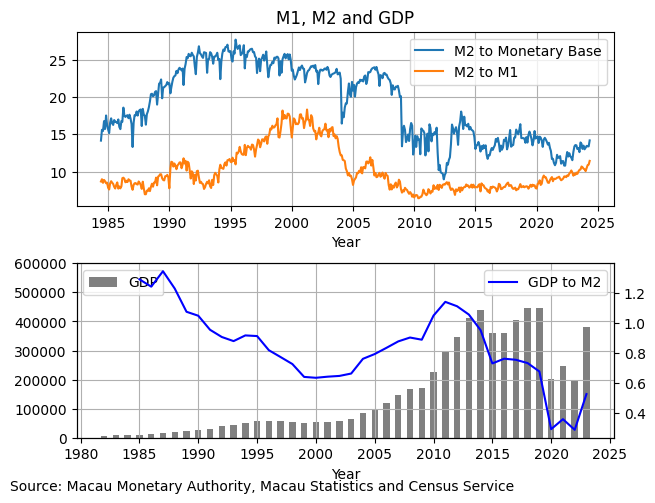

In [11]:
df['m2_monbase']=df['M2']/df['Monetary Base']
df['m2_m1']=df['M2']/df['M1']
df['gdp_m2']=df['GDP']/df['M2']

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(df['m2_monbase'], label='M2 to Monetary Base')
axs[0].plot(df['m2_m1'], label='M2 to M1')
axs[0].set_xlabel('Year')
axs[0].grid(True)
axs[0].legend()

gdp_plt=df.loc[df.index.strftime('%m-%d') == '01-01', 'GDP']
axs[1].bar(df.loc[df.index.strftime('%m-%d') == '01-01'].index, df.loc[df.index.strftime('%m-%d') == '01-01', 'GDP'], 
         label='GDP', color='grey' ,width=200)
# axs[1].bar(df.loc[df.index.strftime('%m-%d') == '01-01'].index, df.loc[df.index.strftime('%m-%d') == '01-01', 'M2'], 
#          label='GDP', color='blue' ,width=200)
axs[1].axis(ymax=600000)
axs[1].set_xlabel('Year')

axs2 = axs[1].twinx()
axs2.plot(df.loc[df.index.strftime('%m-%d') == '01-01']['gdp_m2'], label='GDP to M2', color='blue')


axs[1].grid(True)
axs[1].legend()
axs2.legend()
axs[0].set_title('M1, M2 and GDP')
fig.text(0.0, -0.01, 'Source: Macau Monetary Authority, Macau Statistics and Census Service')
plt.show()

Text(0.0, -0.01, 'Source: Macau Monetary Authority, Macau Statistics and Census Service')

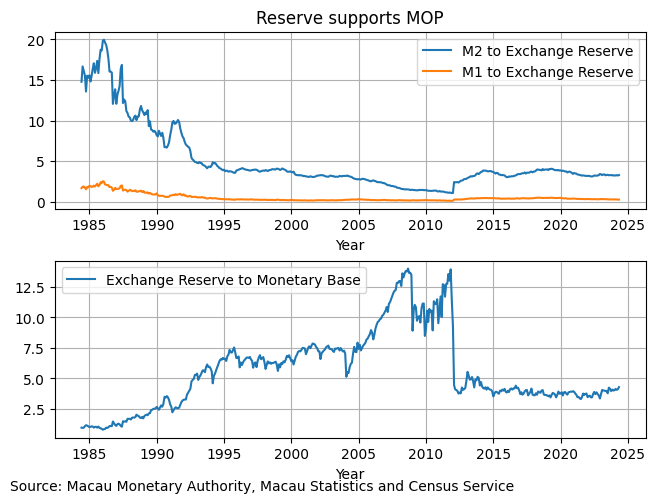

In [12]:
df['m2_reserve']=df['M2']/df['Foreign Exchange Reserves']
df['m1_reserve']=df['M1']/df['Foreign Exchange Reserves']
df['reserve_monbase']=df['Foreign Exchange Reserves']/df['Monetary Base']

fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(df['m2_reserve'], label='M2 to Exchange Reserve')
axs[0].plot(df['m1_reserve'], label='M1 to Exchange Reserve')
axs[0].set_xlabel('Year')
axs[0].grid(True)
axs[0].set_title('Reserve supports MOP')
axs[0].legend()

axs[1].plot(df['reserve_monbase'], label='Exchange Reserve to Monetary Base')
axs[1].set_xlabel('Year')
axs[1].grid(True)
axs[1].legend()

fig.text(0.0, -0.01, 'Source: Macau Monetary Authority, Macau Statistics and Census Service')

In [13]:
df.loc[df.index.strftime('%Y').str.contains('2011|2012')][['reserve_monbase', 'Foreign Exchange Reserves', 'Monetary Base']]

,reserve_monbase,Foreign Exchange Reserves,Monetary Base
Date,,,
2011-01-01,10.617814,191974.18,18080.387
2011-02-01,11.729125,196222.035,16729.469
2011-03-01,10.032189,204084.403,20342.958
2011-04-01,12.729412,208445.654,16375.121
2011-05-01,12.669565,215802.727,17033.16
2011-06-01,11.707161,225691.934,19278.109
2011-07-01,12.743434,231810.75,18190.603
2011-08-01,12.770808,238906.551,18707.238
2011-09-01,13.564336,246839.524,18197.686


In [14]:
df.columns

Index(['Year', 'Month', 'Net Foreign Assets', 'Foreign Assets',
       'Foreign Exchange Reserves', 'Other Foreign Assets', 'Foreign Liab.',
       'Year', 'Month', 'Monetary Base', 'Certificate of Indebtedness',
       'Coins issued', 'Deposits of Banks with the AMCM', 'Year', 'Month',
       'M2', 'M2-MOP', 'M2-HKD', 'M2-RMB', 'M2-USD', 'M2-Others ', 'M1',
       'M1-MOP', 'M1-HKD', 'M1-RMB', 'M1-USD', 'M1-Others ',
       'Quasi-monetary Liab.', 'Liab.-MOP', 'Liab.-HKD', 'Liab.-RMB',
       'Liab.-USD', 'Liab.-Others ', 'period', 'value', 'GDP', 'm2_monbase',
       'm2_m1', 'gdp_m2', 'm2_reserve', 'm1_reserve', 'reserve_monbase'],
      dtype='object')

In [45]:
url='https://www.censtatd.gov.hk/api/get.php?id=310-31001&lang=en&full_series=1'

def read_json(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    r=requests.get(url, headers=headers)
    if r.ok:
        data=r.json()
    return data

data=read_json(url)
hk_gdp=pd.DataFrame(list(filter(lambda i: (i['freq']=='Y') & (int(i['period'][:4])>1980) & (i['svDesc']=='HK$ million') 
                         & (i['sv']=='CUR'), data['dataSet'])))
hk_gdp=hk_gdp.set_index('period')
hk_gdp['gdp']=hk_gdp['figure']
hk_gdp.head()

,freq,sv,svDesc,figure,sd_value,gdp
period,,,,,,
1981,Y,CUR,HK$ million,173578,,173578
1982,Y,CUR,HK$ million,196005,,196005
1983,Y,CUR,HK$ million,217281,,217281
1984,Y,CUR,HK$ million,261992,,261992
1985,Y,CUR,HK$ million,278128,,278128


In [52]:
url='https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/money/supply-adjusted?pagesize=1500'
data=read_json(url)
hk_m2=pd.DataFrame(list(filter(lambda i: '-12' in i['end_of_month'], data['result']['records'])))[['end_of_month', 'm2_total']]
hk_m2['M2']=hk_m2['m2_total']

<Axes: >

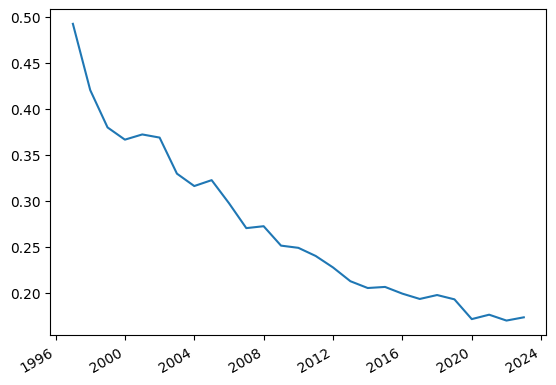

In [62]:
hk_m2.index=hk_m2['end_of_month'].str.slice(0,4)

df2=pd.concat([hk_m2['M2'], hk_gdp['gdp']], axis=1)
df2.index=pd.to_datetime(df2.index, format='%Y')
df2['gdp_m2']=df2['gdp']/df2['M2']
df2['gdp_m2'].plot()

DatetimeIndex(['2023-01-01', '2022-01-01', '2021-01-01', '2020-01-01',
               '2019-01-01', '2018-01-01', '2017-01-01', '2016-01-01',
               '2015-01-01', '2014-01-01', '2013-01-01', '2012-01-01',
               '2011-01-01', '2010-01-01', '2009-01-01', '2008-01-01',
               '2007-01-01', '2006-01-01', '2005-01-01', '2004-01-01',
               '2003-01-01', '2002-01-01', '2001-01-01', '2000-01-01',
               '1999-01-01', '1998-01-01', '1997-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01'],
              dtype='datetime64[ns]', freq=None)